In [20]:
import torch, os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import rearrange, repeat
import copy
import numpy as np
from torchvision import transforms
from torchvision.datasets import MNIST

from modules.networks.unet import UNetModel

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use only the first GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1
train_dataset = MNIST("/data/edherron/data/MNIST", train=True, download=False, transform=tf)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=1
                                           )

def pad(tensor):
    return repeat(tensor, 'b -> b 1 1 1')

In [21]:
class DiffusionModel(nn.Module):
    def __init__(self, model, device, num_timesteps=1000):
        super().__init__()
        self.device = device
        self.model = model.to(self.device)
        self.N = num_timesteps
        
        self.betas = self.linear_beta_schedule(self.N)
        
        self.beta_schedule = self.register_ddpm_schedules(self.betas)
        
        for k, v in self.beta_schedule.items():
            self.register_buffer(k, v.to(self.device))
        
    def linear_beta_schedule(self, timesteps):
        """
        linear schedule, proposed in original ddpm paper
        """
        scale = 1000 / timesteps
        beta_start = scale * 0.0015
        beta_end = scale * 0.0155
        return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float32)
    
    def register_ddpm_schedules(self, betas):
        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value = 1.)
        return {
            'alphas': alphas,
            'alphas_cumprod': alphas_cumprod,
            'alphas_cumprod_prev': alphas_cumprod_prev,
            'sqrt_alphas_cumprod': torch.sqrt(alphas_cumprod),
            'sqrt_one_minus_alphas_cumprod': torch.sqrt(1. - alphas_cumprod),
            'log_one_minus_alphas_cumprod': torch.log(1. - alphas_cumprod),
            'sqrt_recip_alphas_cumprod': torch.sqrt(1. / alphas_cumprod),
            'sqrt_recipm1_alphas_cumprod': torch.sqrt(1. / alphas_cumprod - 1.)
        }
        
    def sample_forward_diffusion(self, x, t, noise):
        x_t = (
            self.sqrt_alphas_cumprod[t, None, None] * x
            + self.sqrt_one_minus_alphas_cumprod[t, None, None] * noise
        )
        return x_t
    
    def get_train_tuple(self, batch):
        x1 = batch.to(self.device)
        x0 = torch.randn_like(x1).to(self.device)
        t = torch.randint(1, self.N, (x1.shape[0],1)).to(self.device).long()
        
        xt = self.sample_forward_diffusion(x1, t, x0).to(self.device)
        
        return xt, t, x0
    
    def diffusion_model_loss(self, batch):
        xt, t, x0 = self.get_train_tuple(batch)
        
        x0_prediction = self.model(xt, t.squeeze() / self.N)
        
        loss = F.mse_loss(x0, x0_prediction)
        
        return loss
    
    @torch.no_grad()
    def reverse_diffusion_step(self, x_start, eps, timestep, timestep_next, eta):
        noise = torch.randn_like(x_start).to(self.device)
        alpha = self.alphas_cumprod[timestep]
        alpha_next = self.alphas_cumprod[timestep_next]
        sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
        c = (1 - alpha_next - sigma ** 2).sqrt()
        return x_start * alpha_next.sqrt() + c * eps + sigma * noise

    
    @torch.no_grad()
    def sample_sde(self, batch, eta=1., num_inference_steps=None, inversion_strength=None, return_all_timesteps=False):
        '''
        DDIM sampling strategy for inference.
        If num_inference_steps == number of training steps AND eta=1 then this is equivalent to 
        the original DDPM reverse diffusion process
        '''
        def get_x_0_hat(x_t, eps, t):
            '''
            get predicted final image from current image, x_t, and predicted noise, \epsilon_{\theta}(x_t, t).
            '''
            return (
                self.sqrt_recip_alphas_cumprod[t] * x_t - 
                self.sqrt_recipm1_alphas_cumprod[t] * eps
            )
            
        if num_inference_steps is None:
            num_inference_steps = self.N
            
        timesteps = torch.linspace(-1, self.N - 1, steps = num_inference_steps + 1)
        timesteps = list(reversed(timesteps.int().tolist()))
        time_pairs = list(zip(timesteps[:-1], timesteps[1:]))
        
        x_i = torch.randn_like(batch).to(self.device)
        imgs = [x_i]
        for time, time_next in tqdm(time_pairs, desc='sampling loop time step'):
            if inversion_strength is not None and time > round(inversion_strength * self.N):
                continue

            t_is = torch.tensor([time / self.N]).to(self.device)
            t_is = t_is.repeat(batch.size(0))
            
            eps = self.model(x_i, t_is)
            x_start = get_x_0_hat(x_i, eps, time)
            
            if time_next < 0:
                img = x_start
                imgs.append(img)
                continue
            
            x_i = self.reverse_diffusion_step(x_start, eps, time, time_next, eta)
            imgs.append(x_i)
            
        ret = img if not return_all_timesteps else torch.stack(imgs, dim = 1)      
        
        return ret

In [22]:
def train_diffusion_model(data_loader, diffusion_model, opt, device):
    diffusion_model.model.train()
    running_loss = 0.0
    for data in data_loader:
        x1, _ = data
        x1 = x1.to(device)
        
        loss = diffusion_model.diffusion_model_loss(x1)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [23]:
# Init all of our models
DM = DiffusionModel(UNetModel(), device)

print("Number of parameters: ", sum(p.numel() for p in DM.model.parameters()))

opt = torch.optim.Adam(DM.model.parameters(), lr=1e-4)

for i in tqdm(range(10)):
    loss_rec = train_diffusion_model(train_loader, DM, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)
    

Number of parameters:  3607873


 10%|█         | 1/10 [00:30<04:35, 30.66s/it]

loss from epoch  0 :  0.30638152955377357


 20%|██        | 2/10 [01:01<04:06, 30.80s/it]

loss from epoch  1 :  0.019375035963318448


 30%|███       | 3/10 [01:32<03:37, 31.01s/it]

loss from epoch  2 :  0.01586703016482135


 40%|████      | 4/10 [02:04<03:08, 31.36s/it]

loss from epoch  3 :  0.015260628836744644


 50%|█████     | 5/10 [02:37<02:38, 31.75s/it]

loss from epoch  4 :  0.01472900944979901


 60%|██████    | 6/10 [03:09<02:08, 32.08s/it]

loss from epoch  5 :  0.014273841552277828


 70%|███████   | 7/10 [03:42<01:37, 32.36s/it]

loss from epoch  6 :  0.013573538531806874


 80%|████████  | 8/10 [04:15<01:05, 32.59s/it]

loss from epoch  7 :  0.013284055103963993


 90%|█████████ | 9/10 [04:48<00:32, 32.73s/it]

loss from epoch  8 :  0.012911408065639911


100%|██████████| 10/10 [05:21<00:00, 32.19s/it]

loss from epoch  9 :  0.012721095903915293


In [25]:
print(type(trajectory))

<class 'torch.Tensor'>


In [26]:
trajectory.shape

torch.Size([1, 1001, 1, 28, 28])

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step: 100%|██████████| 1000/1000 [00:17<00:00, 58.75it/s]


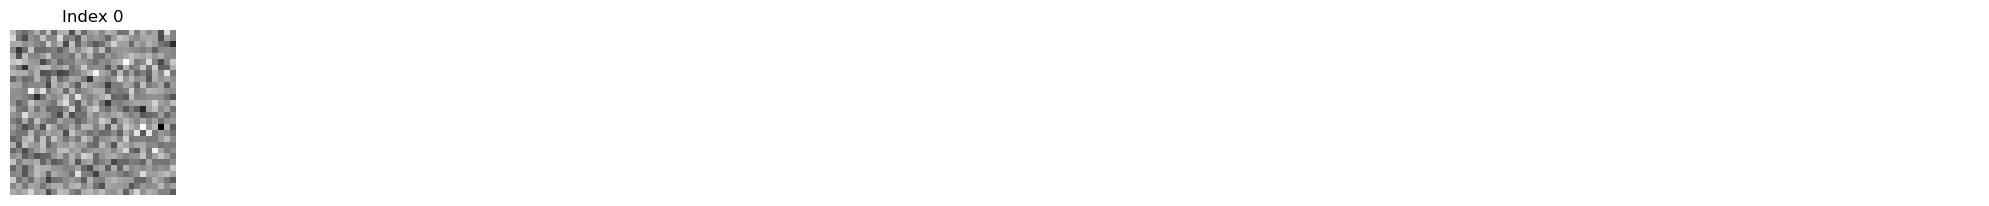

In [27]:
batch = torch.ones((1, 1, 28, 28))
trajectory = DM.sample_sde(batch, return_all_timesteps=True)

# Assuming `data_list` is your list of tensors
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for i, ax in enumerate(axs.flat):
    idx = i * 100  # Every 100th element
    if idx < len(trajectory):
        img = trajectory[0,idx, 0].detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Index {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()
